In [5]:
# Zachary Katz
# zachary_katz@mines.edu
# October 2024

# Make input for LEASTSQUARESGMT.sh

# Imports
import os
import sys

sys.path.insert(
    0,
    "/mnt/c/Users/ZacharyKatz/Desktop/WhillansCatPaper/WhillansCatalogPaper/src/Catalog",
)
import Catalog
import logging

# %load_ext line_profiler

################################################################################
########################## User Defined Variables ##############################
# fmt: off

# Stations, Years, Data Path
dir = "/mnt/d/csrs_2024/all" 
stas = ["la01", "la02", "la03", "la04", "la05", "la06", "la07", "la08", "la09",
        "la10", "la11", "la12", "la13", "la14", "la15", "la16", "la17", "la18",
        "ws04", "ws05",
        "gz01", "gz02", "gz03", "gz04", "gz05", "gz06", "gz07", "gz08", "gz09",
        "gz10", "gz11", "gz12", "gz13", "gz14", "gz15", "gz16", "gz17", "gz18",
        "gz19", "gz20",
        "mg01", "mg02", "mg03", "mg04", "mg05", "mg06", "mg07",
        "slw1"
        ]
#year_arr = [["2007","2008","2009"],["2016","2017","2018","2019"]]
#year_arr = [["2007"],["2008"],["2009"],["2010"],["2011"],["2012"],['2013'],['2014'],['2015'],["2016"],["2017"],["2018"],["2019"]]
year_arr = [['2013']]

# Detection parameters
max_gap_len = 120 # Maximum gap length to interpolate [seconds]
window = 150 # Window size for least-squares averaging [minutes]
slide = 5 # Slide size for least-squares averaging [minutes]
active_stas = 2 # Minimum number of active stations needed for an event
cull_time = 30 # Remove catalog events lasting less than this time [minutes]
cull_dist = 0.1 # Remove catalog events with less than this distance [meters]
plot_bool = False # Flag to plot catalog
min_stas = 2 # Minimum number of stations needed for an event

# Log Level
# Currently implemented: ERROR, WARNING, INFO, DEBUG
# Each level also includes all levels above it.,
loglevel = "INFO" 


# fmt: on
########################## User Defined Variables ##############################
################################################################################


def set_log_level(loglevel: str) -> None:
    """Set logging level for the run

    Parameters
    ----------
    loglevel : str
        Logging level
    """
    FORMAT = "%(asctime)s %(name)s %(levelname)s: %(message)s"
    DATEFMT = "%Y-%m-%d %H:%M:%S"
    if loglevel == "ERROR":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.ERROR, force=True
        )
    elif loglevel == "WARNING":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.WARNING, force=True
        )
    elif loglevel == "INFO":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.INFO, force=True
        )
    elif loglevel == "DEBUG":
        logging.basicConfig(
            format=FORMAT, datefmt=DATEFMT, level=logging.DEBUG, force=True
        )

In [6]:
# Setup logger
set_log_level(loglevel)
logger = logging.getLogger(__name__)

# Convert window and slide to 15 second chunks
window = window * 60 / 15
slide = slide * 60 / 15

# Create Catalog
for years in year_arr:
    cats = []
    for sta in stas:
        interpolation_time, run = Catalog.set_interpolation_time(sta, years)
        if run:
            logger.info(f"Creating Dataframe for {sta}")
            cat = Catalog.Datastream(
                os.path.join(dir, sta), sta, years, interpolation_time
            )
            logger.info(f"Interpolating {sta}")
            if not cat.data.empty:
                cat.findgaps(max_gap_len)
                cats.append(cat)

    logger.info("Creating Catalog")
    picks = Catalog.Picks(cats)
    picks.lls_detection(window, slide)
    sorted_list = picks.on_off_list()
    no_data = picks.no_data_csv(min_stas, sorted_list)

    merged_df = picks.merge()
    merged = Catalog.Events(merged_df)
    threshold = merged.pick_events(sorted_list, active_stas=min_stas)

    catalog = merged.make_catalog(cull_time=30, cull_dist=0.1)

2024-10-15 10:01:01 __main__ INFO: Creating Dataframe for la01
2024-10-15 10:01:23 __main__ INFO: Interpolating la01
2024-10-15 10:01:25 Catalog INFO: 2013-02-02 14:52:00 2013-02-02 14:52:45 0 days 00:00:45
2024-10-15 10:01:36 __main__ INFO: Creating Dataframe for la02
2024-10-15 10:01:52 __main__ INFO: Interpolating la02
2024-10-15 10:01:59 __main__ INFO: Creating Dataframe for la03
2024-10-15 10:01:59 __main__ INFO: Interpolating la03
2024-10-15 10:01:59 __main__ INFO: Creating Dataframe for la04
2024-10-15 10:02:16 __main__ INFO: Interpolating la04
2024-10-15 10:02:26 __main__ INFO: Creating Dataframe for la05
2024-10-15 10:02:33 __main__ INFO: Interpolating la05
2024-10-15 10:02:37 __main__ INFO: Creating Dataframe for la06
2024-10-15 10:02:54 __main__ INFO: Interpolating la06
2024-10-15 10:03:08 __main__ INFO: Creating Dataframe for la07
2024-10-15 10:03:29 __main__ INFO: Interpolating la07
2024-10-15 10:03:42 __main__ INFO: Creating Dataframe for la08
2024-10-15 10:04:03 __main__

In [43]:
# Find indices for LeastSquaresGMT plot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

indices = []
for time in sorted_list["times"]:
    index = merged.merged.index[merged.merged["time"] == time][0]
    indices.append(index)

In [137]:
x_cols = [col for col in merged.merged.columns if col.endswith("x")]
st_time = datetime.datetime.strptime("2013-01-24:06:00:00", "%Y-%m-%d:%H:%M:%S")
end_time = datetime.datetime.strptime("2013-01-29:00:00:00", "%Y-%m-%d:%H:%M:%S")
start = min(merged.merged["time"], key=lambda x: abs(x - st_time))
end = min(merged.merged["time"], key=lambda x: abs(x - end_time))
start = merged.merged.index[merged.merged["time"] == start][0]
end = merged.merged.index[merged.merged["time"] == end][0]
print(start, end)

133920 161280


/tmp/ipykernel_87599/1399794210.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Threshold"] = threshold[st_index:ed_index]
/tmp/ipykernel_87599/1399794210.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=1, how='all', inplace=True)
/tmp/ipykernel_87599/1399794210.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

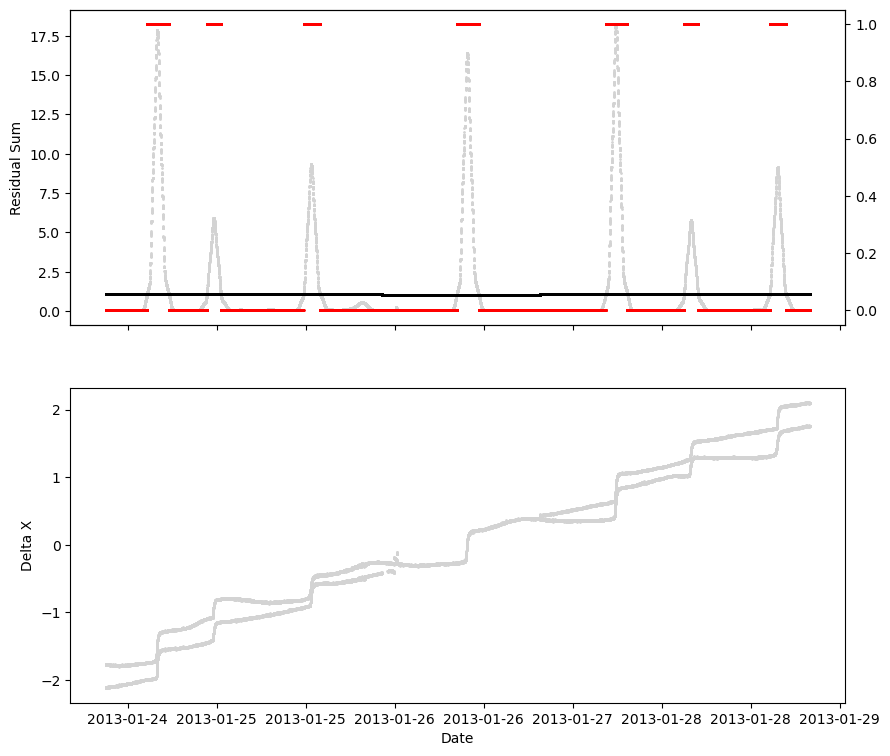

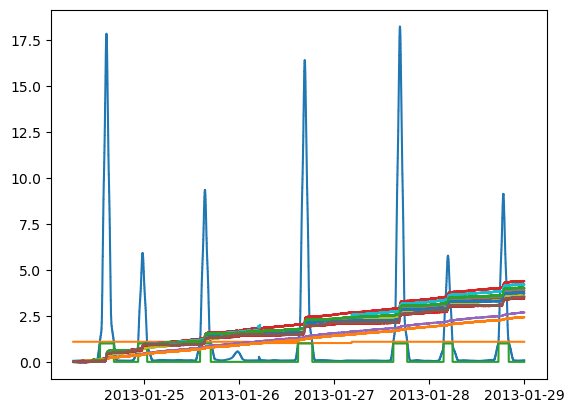

In [139]:
fig, (ax, ax2) = plt.subplots(2, figsize=(10, 9), sharex=True)
st_index = start
ed_index = end
ax.scatter(
    merged.merged["time"][st_index:ed_index],
    merged.merged["ressum"][st_index:ed_index],
    s=1,
    c="lightgray",
)
ax.scatter(
    merged.merged["time"][st_index:ed_index],
    merged.merged["sum_res_avg"][st_index:ed_index],
    s=1,
    c="black",
)
ax3 = ax.twinx()
ax3.scatter(
    merged.merged["time"][st_index:ed_index],
    merged.merged["event"][st_index:ed_index],
    s=1,
    c="red",
)

ax2.scatter(
    merged.merged["time"][st_index:ed_index],
    merged.merged["la09x"][st_index:ed_index]
    - np.mean(merged.merged["la09x"][st_index:ed_index]),
    s=1,
    c="lightgray",
)

ax2.scatter(
    merged.merged["time"][st_index:ed_index],
    merged.merged["gz14x"][st_index:ed_index]
    - np.mean(merged.merged["gz14x"][st_index:ed_index]),
    s=1,
    c="lightgray",
)


# ax2.scatter(merged.merged["time"][st_index:ed_index], merged.merged['la07x'][st_index:ed_index], s=1, c="black")
# Format x label
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax2.set_xlabel("Date")
ax.set_ylabel("Residual Sum")
ax2.set_ylabel("Delta X")

df = merged.merged[st_index:ed_index]
df["Threshold"] = threshold[st_index:ed_index]
df.dropna(axis=1, how="all", inplace=True)

fig, ax = plt.subplots()
ax.plot(df["time"], df["ressum"], label="Ressum")
ax.plot(df["time"], df["Threshold"], label="Threshold")
ax.plot(df["time"], df["event"], label="Event")
x_cols = [col for col in df if col.endswith("x")]
for x_col in x_cols:
    df[x_col] = (
        df[x_col] - np.mean(df[x_col]) - (df[x_col].iloc[0] - np.mean(df[x_col]))
    )
    ax.plot(df["time"], df[x_col], label=x_col)
# ax.set_ylim(0,5)
df.to_csv("LeastSquaresGMT.txt", sep="\t", index=False, na_rep="NaN")

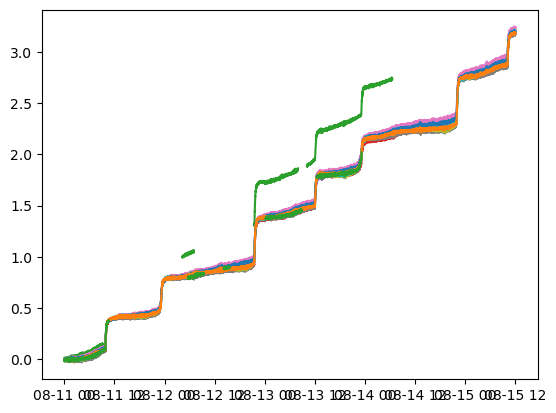

In [98]:
cv = pd.read_csv("LeastSquaresGMT.txt", sep="\t", parse_dates=["time"])
for x_j in x_cols:
    plt.plot(cv["time"], cv[x_j], label=x_j)